# Neural Networks with TensorFlow

```{admonition} Attribution
This notebook follows Chapter 13: *Implementing a Multilayer Artificial Neural Network from Scratch* of {cite}`RaschkaMirjalili2019`.
```

In this notebook, we cover TensorFlow's programming model. We start with creating and manipulating tensors. Then, we will see how to load data and utilize 
TensorFlow `Dataset` objects, which will allow us to iterate through a dataset 
efficiently. We also look at ready-to-use datasets in the 
`tensorflow_datasets` submodule and learn how to use them.

Finally, the `tf.keras` API will be introduced and we will 
move forward to building machine learning models, learn how to compile and train 
the models, and learn how to save the trained models on disk for future evaluation.

## TensorFlow Tensors

```{margin}
**GPU availability**
```

In case you want to use GPUs (recommended), you need a compatible NVIDIA 
graphics card, along with the CUDA Toolkit and the NVIDIA cuDNN library to be 
installed.

In [2]:
import tensorflow as tf

tf.random.set_seed(42)
print(tf.__version__)
print(tf.config.list_physical_devices())

2.7.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Creating tensors in TensorFlow

Now, let's consider a few different ways of creating tensors, and then see some of 
their properties and how to manipulate them. Firstly, we can simply create a tensor 
from a list or a NumPy array using the tf.convert_to_tensor function as follows:

In [3]:
import numpy as np

a = np.arange(3, dtype=np.int32)
b = [0, 1, 2]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

print(t_a)
print(t_b)

Metal device set to: tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)


2022-01-04 01:04:19.502836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-04 01:04:19.503252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



We can initialize tensors with specific structure, e.g. full of ones:

In [4]:
t = tf.ones((2, 3))
print(t.shape)
print(t.numpy())

(2, 3)
[[1. 1. 1.]
 [1. 1. 1.]]


To initialize non-trainable parameters, we initialize the tensor using `tf.constant`. (This is equivalent to setting `requires_grad=False` in PyTorch). 

In [5]:
tf.constant([-1.0, np.pi])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.       ,  3.1415927], dtype=float32)>

### Manipulating the data type and shape of a tensor

Learning ways to manipulate tensors is necessary to make them compatible for input 
to a model or an operation. In this section, you will learn how to manipulate tensor 
data types and shapes via several TensorFlow functions that cast, reshape, transpose, 
and squeeze.

In [6]:
t_a_new = tf.cast(t_a, tf.int64)
print(t_a.dtype)
print(t_a_new.dtype)

<dtype: 'int32'>
<dtype: 'int64'>


As you will see in upcoming chapters, certain operations require that the input 
tensors have a certain number of dimensions (that is, **rank**) associated with 
a certain number of elements (shape). Thus, we might need to change the shape 
of a tensor, add a new dimension, or squeeze an unnecessary dimension. TensorFlow 
provides useful functions (or operations) to achieve this, such as `tf.transpose()`, 
`tf.reshape()`, and `tf.squeeze()`. Let's take a look at some examples:

**Transposing a tensor:**

In [7]:
t = tf.random.uniform(shape=(3, 5))
t_tr = tf.transpose(t)
print(t.shape, " -> ", t_tr.shape)

(3, 5)  ->  (5, 3)


**Reshaping a tensor** (e.g. rank 1 to rank 2):

In [8]:
t = tf.zeros(30)
print(tf.reshape(t, (5, 6)))

tf.Tensor(
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], shape=(5, 6), dtype=float32)


**Removing the unnecessary dimensions**:

In [9]:
t = tf.zeros(shape=(1, 1, 5)) # specify which axis to squeeze out
t_sqz = tf.squeeze(t, axis=[0, 1])
print(t.shape, ' -> ', t_sqz.shape)

(1, 1, 5)  ->  (5,)


In [10]:
print(t)
print(t_sqz)

tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


### Applying mathematical operations to tensors

Applying mathematical operations, in particular linear algebra operations, is 
necessary for building most machine learning models. In this subsection, we will 
cover some widely used linear algebra operations, such as element-wise product, 
matrix multiplication, and computing the norm of a tensor.

**Product**. We can compute element-wise product of two tensors with `tf.multiply` as follows:

In [11]:
t1 = tf.random.uniform(shape=(5, 2), minval=-1.0, maxval=1.0) # U[-1, 1)
t2 = tf.random.normal(shape=(5, 2), mean=0.0, stddev=1.0)

# element-wise multiplication
t3 = tf.multiply(t1, t2)
print(t3.numpy())

[[-0.08941577 -0.02458418]
 [-0.10607267  0.8317226 ]
 [-0.30281588  0.45440775]
 [ 0.02085974  1.8071482 ]
 [-0.02642325 -0.6907476 ]]


**Reduction**. To compute the mean, sum, and standard deviation along a certain axis (or axes), we can use `tf.math.reduce_mean()`, `tf.math.reduce_sum()`, and `tf.math.reduce_
std()`. For example, the mean of each column in `t1` can be computed as follows:

In [12]:
_ = tf.math.reduce_mean(t1, axis=0) # "collapse" axis zero -> vector along column
print(_)
print(t1.shape, ' -> ', _.shape)

tf.Tensor([-0.0570128   0.04285016], shape=(2,), dtype=float32)
(5, 2)  ->  (2,)


**Matrix product**. Matrix product between two tensors with rank > 1 can be computed using  the `tf.linalg.matmul()` function as follows.

In [13]:
t = tf.random.uniform(shape=[32, 5, 2], minval=-1, maxval=1)
s = tf.random.uniform(shape=[32, 2, 8], minval=-1, maxval=1)

tf.linalg.matmul(t, s).shape

TensorShape([32, 5, 8])

```python
tf.linalg.matmul(
    a, b, transpose_a=False, transpose_b=False, adjoint_a=False, adjoint_b=False,
    a_is_sparse=False, b_is_sparse=False, name=None
)
```

Here adjoint means to take the conjugate transpose before multiplication. The other arguments have similar use. Observe that we performed batch matrix multiplication above with the last two indices. More precisely, this function returns:

> A `tf.Tensor` of the same type as `a` and `b` where each inner-most matrix is the product of the corresponding matrices in `a` and `b`, e.g. if all transpose or adjoint attributes are `False`: `output[..., i, j] = sum_k (a[..., i, k] * b[..., k, j])`, for all indices `i`, `j`.




For example, we have batch index zero:

In [14]:
tf.reduce_all(t[0, :, :] @ s[0, :, :] == tf.linalg.matmul(t, s)[0, :, :]).numpy()

True

**Tensor norm**. Finally, the `tf.norm()` function is useful for computing the ${L}^p$ norm of a tensor. 
For example, we can find the ${L}^2$ norm of `t1` as follows:

In [15]:
print(tf.norm(t1))

tf.Tensor(1.2627555, shape=(), dtype=float32)


In [16]:
print(tf.sqrt(tf.reduce_sum(tf.reshape(tf.multiply(t1, t1), 10))))

tf.Tensor(1.2627554, shape=(), dtype=float32)


### Split, stack, and concatenate tensors

In this subsection, we will cover TensorFlow operations for splitting a tensor into 
multiple tensors, or the reverse: stacking and concatenating multiple tensors into 
a single one.

**Split**. Assume that we have a single tensor and we want to split it into two or more tensors. 
For this, TensorFlow provides a convenient `tf.split()` function, which divides 
an input tensor into a list of equally-sized tensors.

In [17]:
t = tf.random.uniform(shape=[10, 3])
print(t)

tf.Tensor(
[[0.7435287  0.3143711  0.07390559]
 [0.461097   0.47011137 0.48218763]
 [0.00466847 0.4205432  0.17800355]
 [0.999537   0.92980945 0.0266701 ]
 [0.7094693  0.41157687 0.86645055]
 [0.79667795 0.5442493  0.9442544 ]
 [0.91933596 0.99775696 0.9314389 ]
 [0.26405907 0.728246   0.2333914 ]
 [0.82305324 0.2585187  0.53446186]
 [0.93713117 0.13924801 0.5792124 ]], shape=(10, 3), dtype=float32)


In [18]:
tf.split(t, num_or_size_splits=2, axis=0) # num splits (int)

[<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0.7435287 , 0.3143711 , 0.07390559],
        [0.461097  , 0.47011137, 0.48218763],
        [0.00466847, 0.4205432 , 0.17800355],
        [0.999537  , 0.92980945, 0.0266701 ],
        [0.7094693 , 0.41157687, 0.86645055]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0.79667795, 0.5442493 , 0.9442544 ],
        [0.91933596, 0.99775696, 0.9314389 ],
        [0.26405907, 0.728246  , 0.2333914 ],
        [0.82305324, 0.2585187 , 0.53446186],
        [0.93713117, 0.13924801, 0.5792124 ]], dtype=float32)>]

In [19]:
tf.split(t, num_or_size_splits=[8, 2], axis=0) # size splits (List[int])

[<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
 array([[0.7435287 , 0.3143711 , 0.07390559],
        [0.461097  , 0.47011137, 0.48218763],
        [0.00466847, 0.4205432 , 0.17800355],
        [0.999537  , 0.92980945, 0.0266701 ],
        [0.7094693 , 0.41157687, 0.86645055],
        [0.79667795, 0.5442493 , 0.9442544 ],
        [0.91933596, 0.99775696, 0.9314389 ],
        [0.26405907, 0.728246  , 0.2333914 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.82305324, 0.2585187 , 0.53446186],
        [0.93713117, 0.13924801, 0.5792124 ]], dtype=float32)>]

**Concat and stack**. Sometimes, we are working with multiple tensors and need to concatenate or stack 
them to create a single tensor. In this case, TensorFlow functions such as `tf.stack()`
and `tf.concat()` come in handy. Note that concatenating joins a sequence of tensors along an existing axis, while stacking joins a sequence of tensors along a new axis.


In [20]:
u = tf.ones(3,)
v = tf.zeros(3,)

tf.concat([u, v], axis=0)

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0.], dtype=float32)>

In [21]:
tf.stack([u, v], axis=0)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [0., 0., 0.]], dtype=float32)>

In [22]:
tf.stack([u, v], axis=1)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

## Building input pipelines using `tf.data`

```{margin}
Note that these are all analogous to the `Dataset` and `DataLoader` API of PyTorch.
```

When we are training a deep NN model, we usually train the model using SGD and its variants. 
In cases where the training dataset is small and can 
be loaded as a tensor into the memory, TF models (that are built with the 
Keras API) can be trained directly with this dataset tensor via their `.fit()` method. In 
typical use cases, however, the dataset is too large to fit into the computer 
memory, and we will need to load the data from the main storage device in chunks. In addition, we may need to construct a data-processing 
pipeline to apply certain transformations and preprocessing steps to our data. Applying preprocessing functions manually every time can be quite cumbersome. TensorFlow provides a special class for constructing efficient and convenient preprocessing pipelines.

In this section, we will see an overview of different methods for constructing a TensorFlow `Dataset` including dataset transformations and common preprocessing steps for images and tabular data.

### Creating a TensorFlow Dataset from existing tensors

In [23]:
a = tf.range(10)
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)

<TensorSliceDataset shapes: (), types: tf.int32>


In [24]:
for item in ds:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [25]:
ds_batch = ds.batch(4, drop_remainder=False) # Analogous to drop_last in PyTorch
for batch in ds_batch:
    print(batch)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


### Combining two tensors into a joint dataset

In [26]:
import pandas as pd

X = tf.random.uniform([10, 3], dtype=tf.float32)
y = tf.range(10)

feature_set = tf.data.Dataset.from_tensor_slices(X)
label_set   = tf.data.Dataset.from_tensor_slices(y)

ds_joint = tf.data.Dataset.zip((feature_set, label_set))
for x, t in ds_joint.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.954663  0.880462  0.975766  0
1  0.205636  0.269730  0.271287  1
2  0.716818  0.746221  0.177239  2
3  0.570819  0.641031  0.263493  3 

         X1        X2        X3  y
0  0.947902  0.641497  0.612335  4
1  0.446665  0.955385  0.791269  5
2  0.344447  0.540676  0.530983  6
3  0.827745  0.978544  0.484433  7 

         X1        X2        X3  y
0  0.245219  0.632473  0.584837  8
1  0.733694  0.920473  0.464643  9 



Alternatively, we could have started with the raw tensors:

In [27]:
ds_joint = tf.data.Dataset.from_tensor_slices((X, y))
print(ds_joint)

<TensorSliceDataset shapes: ((3,), ()), types: (tf.float32, tf.int32)>


### Transformations

We can also apply transformations to each individual element of the dataset.

In [28]:
X_max = tf.reduce_max(X, axis=0)
X_min = tf.reduce_min(X, axis=0)
ds_transformed = ds_joint.map(lambda x, y: (tf.math.divide(x - X_min, X_max - X_min), y))
for x, t in ds_transformed.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  1.000000  0.861626  1.000000  0
1  0.000000  0.000000  0.117776  1
2  0.682461  0.672238  0.000000  2
3  0.487543  0.523834  0.108017  3 

         X1        X2        X3  y
0  0.990974  0.524492  0.544873  4
1  0.321789  0.967327  0.768954  5
2  0.185321  0.382253  0.442996  6
3  0.830556  1.000000  0.384701  7 

         X1        X2        X3  y
0  0.052846  0.511760  0.510437  8
1  0.704992  0.918073  0.359918  9 



2022-01-04 01:04:20.254353: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Applying this sort of transformation can be used for a user-defined function. 
For example, if we have a dataset created from the list of image filenames on disk, 
we can define a function to load the images from these filenames and apply that 
function by calling the `.map()` method. 

### Shuffle, Batch, and Repeat = Epoch

To train a neural network using SGD, 
it is important to feed training data as randomly shuffled batches. (Otherwise, it biases the weight updates with the ordering of the input data.) TF provides a `.shuffle` method on dataset objects with a `buffer_size` parameter. This [answer](https://stackoverflow.com/a/47025850) in SO provides a good explanation for `buffer_size`:

> [`Dataset.shuffle()` is designed] to handle datasets that are too large to fit in memory. Instead of shuffling the entire dataset, it maintains a buffer of `buffer_size` elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available). <br><br>
Changing the value of `buffer_size` affects how uniform the shuffling is: if `buffer_size` is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all. For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer. However, the appropriate choice will depend on the exact nature of your training job.

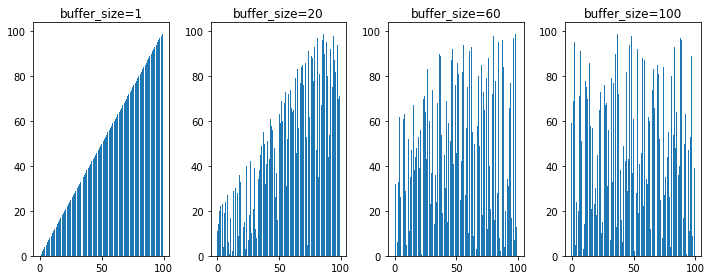

In [29]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(10, 4))
buffer_size = [1, 20, 60, 100]
for i in range(len(buffer_size)):
    shuffled_data = []
    ds_range = tf.data.Dataset.from_tensor_slices(tf.range(100))
    for x in ds_range.shuffle(buffer_size[i]).batch(1):
        shuffled_data.append(x.numpy()[0])

    ax = fig.add_subplot(1, 4, i+1)
    ax.bar(range(100), shuffled_data)
    ax.set_title(f"buffer_size={buffer_size[i]}")

plt.tight_layout()
plt.show()

Furthermore, `shuffle` has an important argument `reshuffle_each_iteration` that controls whether the shuffle order should be different each time the dataset is iterated over. This is set to `True` by default. 

In [30]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[2, 1, 0, 1, 0, 2]

In [31]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3, reshuffle_each_iteration=False)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[2, 1, 0, 2, 1, 0]

When training a model for multiple epochs, we need to shuffle and iterate over the dataset by the desired number of epochs. To repeat the dataset, we use the `.repeat` method on the dataset object. The following pattern is the correct order of creating epochs. For training, it is recommended to set `drop_remainder=True` in `.batch()` to drop the last minibatch of size 1. 

In [32]:
buffer_size = 6
for x, t in ds_transformed.shuffle(buffer_size).batch(3).repeat(2):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.000000  0.000000  0.117776  1
1  0.990974  0.524492  0.544873  4
2  0.682461  0.672238  0.000000  2 

         X1        X2        X3  y
0  1.000000  0.861626  1.000000  0
1  0.185321  0.382253  0.442996  6
2  0.704992  0.918073  0.359918  9 

         X1        X2        X3  y
0  0.052846  0.511760  0.510437  8
1  0.487543  0.523834  0.108017  3
2  0.830556  1.000000  0.384701  7 

         X1        X2        X3  y
0  0.321789  0.967327  0.768954  5 

         X1        X2        X3  y
0  0.000000  0.000000  0.117776  1
1  0.185321  0.382253  0.442996  6
2  0.682461  0.672238  0.000000  2 

         X1        X2        X3  y
0  0.052846  0.511760  0.510437  8
1  0.321789  0.967327  0.768954  5
2  0.704992  0.918073  0.359918  9 

         X1        X2        X3  y
0  1.000000  0.861626  1.000000  0
1  0.990974  0.524492  0.544873  4
2  0.830556  1.000000  0.384701  7 

         X1        X2        X3  y
0  0.487543  0.523834  0.108017  3 



To see this more transparently, consider the simple dataset:

In [33]:
dataset = tf.data.Dataset.range(10).shuffle(6).batch(3).repeat(2)
list(dataset.as_numpy_iterator())

[array([4, 6, 0]),
 array([1, 3, 9]),
 array([5, 8, 2]),
 array([7]),
 array([2, 0, 3]),
 array([6, 7, 9]),
 array([1, 5, 4]),
 array([8])]

### Creating a dataset from files on your local storage disk

We can get filenames using `.glob` on a `pathlib.Path` object as follows:

In [34]:
import pathlib
import os

cat_imgdir_path = pathlib.Path("../../../input/cat2dog/cat2dog/trainA")
dog_imgdir_path = pathlib.Path("../../../input/cat2dog/cat2dog/trainB")

cat_file_list = sorted([str(path) for path in cat_imgdir_path.glob("*.jpg")])
dog_file_list = sorted([str(path) for path in dog_imgdir_path.glob("*.jpg")])

Visualizing image sets for cats and dogs:

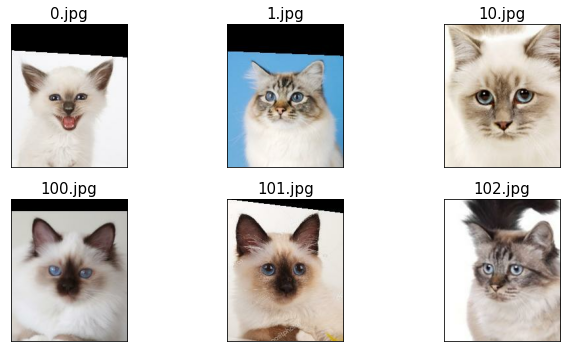

In [35]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(cat_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

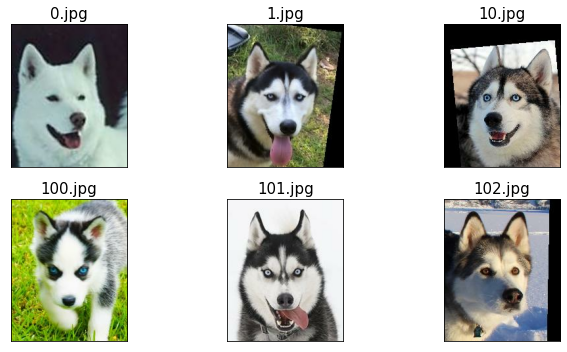

In [36]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(dog_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

Instead of having a dataset of arrays for images, and their corresponding labels, we can create a dataset of filenames and their labels. Then, we can transform the filenames to images using a mapping to load and preprocess images given their filenames.

0


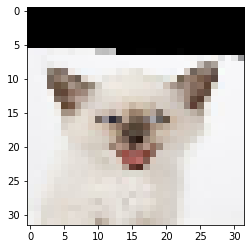

In [37]:
from functools import partial

# Define mapping function: (filename, label) -> (RGB array, label)
def load_and_preprocess(path, label, img_width=124, img_height=124):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img /= 255.0
    return img, label

# Create dataset of RGB arrays resized to 32x32x3
filenames = cat_file_list + dog_file_list
labels = [0] * len(cat_file_list) + [1] * len(dog_file_list)
filenames_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
images_dataset = filenames_dataset.map(partial(load_and_preprocess, img_width=32, img_height=32))

# Display one image and its label (0 = cat, 1 = dog) 
img, label = next(iter(images_dataset.batch(1)))
print(label.numpy()[0])
plt.imshow(img[0, :, :, :]);

### Fetching datasets from the `tensorflow_datasets` library

The `tensorflow_datasets` library provides a nice collection of freely available 
datasets for training or evaluating deep learning models. The datasets are nicely 
formatted and come with informative descriptions, including the format of features 
and labels and their type and dimensionality, as well as the citation of the original 
paper that introduced the dataset in BibTeX format. Another advantage is that these 
datasets are all prepared and ready to use as `tf.data.Dataset` objects, so all the 
functions we covered in the previous sections can be used directly.

In [38]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders())) # no. of available datasets
print(tfds.list_builders()[:5])

1001
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


The book outlines two ways of loading datasetes from `tfds`. The first approach consists of three steps:
1. Calling the dataset builder function
2. Executing the `download_and_prepare()` method
3. Calling the `as_dataset()` method

In [39]:
coil100_bldr = tfds.builder('coil100')
print(coil100_bldr.info.features)
print('\n', coil100_bldr.info.citation)

FeaturesDict({
    'angle': tf.int64,
    'angle_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=72),
    'image': Image(shape=(128, 128, 3), dtype=tf.uint8),
    'object_id': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})

 @article{nene1996columbia,
  title={Columbia object image library (coil-20)},
  author={Nene, Sameer A and Nayar, Shree K and Murase, Hiroshi and others},
  year={1996},
  publisher={Technical report CUCS-005-96}
}


In [40]:
coil100_bldr.download_and_prepare()

In [41]:
dataset = coil100_bldr.as_dataset(shuffle_files=True)
print(type(dataset))
print(dataset)

<class 'dict'>
{'train': <_OptionsDataset shapes: {angle: (), angle_label: (), image: (128, 128, 3), object_id: ()}, types: {angle: tf.int64, angle_label: tf.int64, image: tf.uint8, object_id: tf.int64}>}


In [42]:
dataset.keys()

dict_keys(['train'])

As we can see above, dataset objects are type `dict` that come already split. In this example, though, there is only a train set.

In [43]:
train_dataset = dataset['train']
print(train_dataset)
print(isinstance(train_dataset, tf.data.Dataset))
print(len(train_dataset))

<_OptionsDataset shapes: {angle: (), angle_label: (), image: (128, 128, 3), object_id: ()}, types: {angle: tf.int64, angle_label: tf.int64, image: tf.uint8, object_id: tf.int64}>
True
7200


In [44]:
example = next(iter(train_dataset))
print(type(example))
print(example.keys())

<class 'dict'>
dict_keys(['angle', 'angle_label', 'image', 'object_id'])


2022-01-04 01:04:22.014403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Note that the elements of this dataset come in a dictionary. If we want to pass this 
dataset to a supervised deep learning model during training, we have to reformat 
it as a tuple of (features, label). We will do this by applying a transformation via `map()`:

In [45]:
train_dataset = train_dataset.map(lambda d: (
    {k: d[k] for k in d.keys() if k != 'object_id'},
    d['object_id']
))

# Try one example
features, labels = next(iter(train_dataset.batch(8)))
print(features['angle'].shape)
print(features['angle_label'].shape)
print(features['image'].shape)
print(labels.numpy().shape)

(8,)
(8,)
(8, 128, 128, 3)
(8,)


2022-01-04 01:04:22.061101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


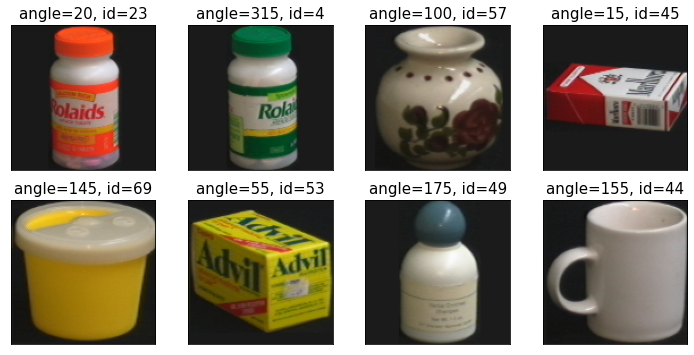

In [46]:
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = features['image'][i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(f"angle={features['angle'][i]}, id={labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

Next, we will proceed with the second approach for fetching a dataset from 
tensorflow_datasets. There is a wrapper function called `load()` that **combines** 
the three steps for fetching a dataset in one. Let's see how it can be used to fetch the 
MNIST digit dataset.

In [47]:
MNIST, MNIST_info = tfds.load('mnist', with_info=True, shuffle_files=False)
print(MNIST_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/particle1331/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [48]:
train_dataset, test_dataset = MNIST['train'], MNIST['test']
train_dataset = train_dataset.map(lambda d: (d['image'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['image'], d['label']))

print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<MapDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


2022-01-04 01:04:22.501838: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


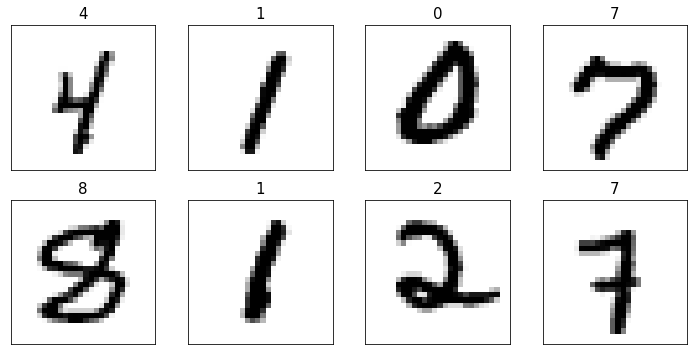

In [49]:
images, labels = next(iter(train_dataset.batch(8)))
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = images[i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"{labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

## Building and training neural networks with Keras

So far we have learned about the basic utility components of 
TensorFlow for manipulating tensors and organizing data into formats that we 
can iterate over during training. In this section, we will finally implement our first 
predictive model in TensorFlow.

### The Keras API

Keras is a high-level neural network API that runs on top of TensorFlow. Keras provides a user-friendly and modular programming interface that allows easy prototyping and the building of 
complex models in just a few lines of code. Keras is 
tightly integrated into TensorFlow and its modules are accessible through `tf.keras`. 
In TensorFlow 2.0, `tf.keras` has become the primary and recommended approach 
for implementing models. This has the advantage that it supports TensorFlow specific functionalities, such as dataset pipelines using `tf.data`. We will be using `tf.keras` to build our neural network models.

```{margin}
This is similar to PyTorch where a model can be defined through `nn.Sequential` or by subclassing `nn.Module` and defining `.forward()` to specify forward pass. 
```

The most commonly used approach for 
building an NN in TensorFlow is through `tf.keras.Sequential()`, which allows 
stacking layers to form a network. A stack of layers can be given in a Python list to 
a model defined as `tf.keras.Sequential()`. Alternatively, the layers can be added 
one by one using the `.add()` method. Furthermore, `tf.keras` allows us to define a model by subclassing `tf.keras.Model`. This gives us more control over the forward pass by defining the `call()` method for our model class to specify the forward pass explicitly. We will see examples of both of these approaches for building an NN model. Finally, as you will see in the following subsections, models built using the `tf.keras` API can be compiled and trained via the `.compile()` and `.fit()` methods.

### Building a linear regression model

Generate artificial sample:

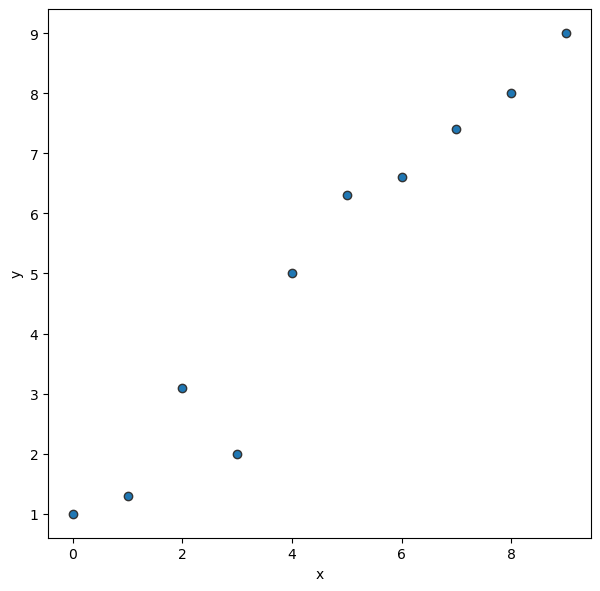

In [50]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.figure(figsize=(7, 7), dpi=100)
plt.scatter(X_train, y_train, edgecolor="#333")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Create TF dataset:

In [51]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_train_norm, tf.float32), 
        tf.cast(y_train, tf.float32)
    )
)

To solve this regression problem, we will define a new class derived from the `tf.keras.Model` class. Subclassing `tf.keras.Model` allows us to use the Keras tools for 
exploring a model, training, and evaluation. In the constructor of our class, we will 
define and initialize the parameters of our model, `w` and `b`, which correspond to the weight and the bias parameters, respectively. Finally, we will define the `call()` method to compute $f(x) = wx + b,$ i.e. to implement a linear model.

In [52]:
class RegressionModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.Variable(0.0, name='weight') # learnable!
        self.b = tf.Variable(0.0, name='bias')
    
    def call(self, x):
        return self.w * x + self.b

#### Model build and summary

The TensorFlow Keras API provides a method named 
`.summary()` for models that are instantiated from `tf.keras.Model`, which allows 
us to get a summary of the model components layer by layer and the number of 
parameters in each layer. In order to be able to 
call `model.summary()`, we first need to specify the dimensionality of the input 
(the number of features) to this model. We can do this by calling `model.build()`
with the expected shape of the input data:

In [53]:
model = RegressionModel()
model.build(input_shape=(None, 1))
model.summary()

Model: "regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Note that we used `None` as a placeholder for the first dimension of the expected input 
tensor via `model.build()`, which allows us to use an arbitrary batch size. However, 
the number of features is fixed (here 1) as it directly corresponds to the number 
of weight parameters of the model.

#### MSE Loss and Backpropagation with `tf.GradientTape`

Next, we define the loss function, which we choose to be MSE, and the training function which implements gradient descent. The details of `tf.GradientTape` will be covered in a separate notebook.

In [54]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    
    dw, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

Now, we can set the hyperparameters and train the model for 200 epochs. We 
will create a batched version of the dataset and repeat the dataset with `count=None`, 
which will result in an infinitely repeated dataset:

In [55]:
from tqdm import tqdm
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(1)
ds_train = ds_train.repeat(count=num_epochs)

ws, bs = [], []
for i, batch in enumerate(ds_train):

    ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)
    train(model, bx, by, learning_rate=learning_rate)
    
    if i%log_steps==0:
        print(f'Epoch {i//steps_per_epoch:4d} Loss {loss_val:6.4f}')


Epoch    0 Loss 43.5600
Epoch   10 Loss 0.7530
Epoch   20 Loss 20.1759
Epoch   30 Loss 23.3976
Epoch   40 Loss 6.3481
Epoch   50 Loss 4.6356
Epoch   60 Loss 0.2411
Epoch   70 Loss 0.2036
Epoch   80 Loss 3.8177
Epoch   90 Loss 0.9416
Epoch  100 Loss 0.7035
Epoch  110 Loss 0.0348
Epoch  120 Loss 0.5404
Epoch  130 Loss 0.1170
Epoch  140 Loss 0.1195
Epoch  150 Loss 0.0944
Epoch  160 Loss 0.4670
Epoch  170 Loss 2.0695
Epoch  180 Loss 0.0020
Epoch  190 Loss 0.3612


Final Parameters: w=2.6577, b=4.8799


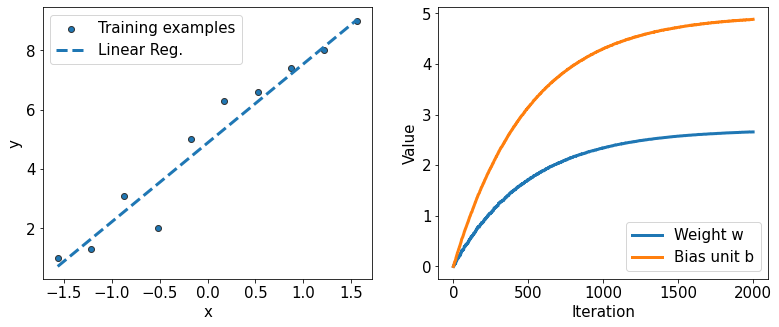

In [56]:
print(f'Final Parameters: w={model.w.numpy():.4f}, b={model.b.numpy():.4f}')

# Generate test set
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

# Get predictions on test set
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_train_norm, y_train, c="#1F77B4", edgecolor="#333")
plt.plot(X_test_norm, y_pred, linestyle="--", color='#1F77B4', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Training converges to the optimal value for the weight and bias.

### Model training via `.compile()` and `.fit()` methods

In the previous example, we saw how to train a model by writing a custom 
function, `train()`, and applied stochastic gradient descent optimization. However, 
writing the `train()` function can be a repeatable task across different projects. The 
TensorFlow Keras API provides a convenient `.fit()` method that can be called 
on an instantiated model. 

In [57]:
tf.random.set_seed(1)

model = RegressionModel()
model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

# Can pass raw dataset directly without needing to create a dataset
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 4ms/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
 1/10 [==>...........................] - ETA: 0s - loss: 3.6847 - mae: 1.9196 - mse: 3.6847

2022-01-04 01:04:30.535939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 4ms/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1055 - mae: 0.9674 - mse: 1.1055
Epoch 11/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8719 - mae: 0.8633 - mse: 0.8719
Epoch 12/200
10/10 [==============================] - 0s 4ms/step - loss: 0.7171 - mae: 0.7713 - mse: 0.7171
Epoch 13/200
10/10 [=================

### Building an MLP for classifying the Iris dataset

TensorFlow instead provides already defined layers through `tf.keras.layers` that 
can be readily used as the building blocks of an NN model. In this section, you will 
learn how to use these layers to solve a classification task using the Iris flower dataset 
and build a two-layer MLP using the Keras API.

In [58]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info.splits) 

{'train': <SplitInfo num_examples=150, num_shards=1>}


This only has a train set. We will have to manually split to be able to validate later. To do this, we have to use `.take()` and `.skip()` methods. But this can lead to some unexpected behavior after calling `.shuffle` which converts the dataset to a `ShuffleDataset` since this would shuffle the after the initial take to create the train dataset. A workaround is to simply set `reshuffle_each_iteration` to `False`. 

In [59]:
tf.random.set_seed(1)

# Shuffle data
dataset_orig = iris['train']
N = len(dataset_orig)
dataset_shuffled = dataset_orig.shuffle(N, reshuffle_each_iteration=False)

# Split into train and test sets; transform
train_dataset = dataset_shuffled.take(100)
test_dataset = dataset_shuffled.skip(100)
print(len(train_dataset), len(test_dataset))

train_dataset = train_dataset.map(lambda d: (d['features'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['features'], d['label']))

100 50


Creating a sequential model:

In [60]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')
])

iris_model.summary() # No need to call .build(), input_shape passed in first dense layer.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Training:

In [126]:
iris_model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

# Recall shuffle, batch, repeat pattern to create epochs
train_dataset = train_dataset.shuffle(buffer_size=training_size)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=1000) # Prepare next elements 
                                                         # while current is preprocessed. 
                                                         # Trades off latency with memory.

# Train model
history = iris_model.fit(train_dataset, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=1)

Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 1.0436 - accuracy: 0.4100


2022-01-04 01:04:37.492101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 0.9617 - accuracy: 0.6100
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.9097 - accuracy: 0.7200
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 0.8628 - accuracy: 0.7200
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.8168 - accuracy: 0.7200
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.7799 - accuracy: 0.7300
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.7520 - accuracy: 0.7200
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 0.7184 - accuracy: 0.7200
Epoch 9/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.7200
Epoch 10/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.7200
Epoch 11/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.7200
Epoch 12

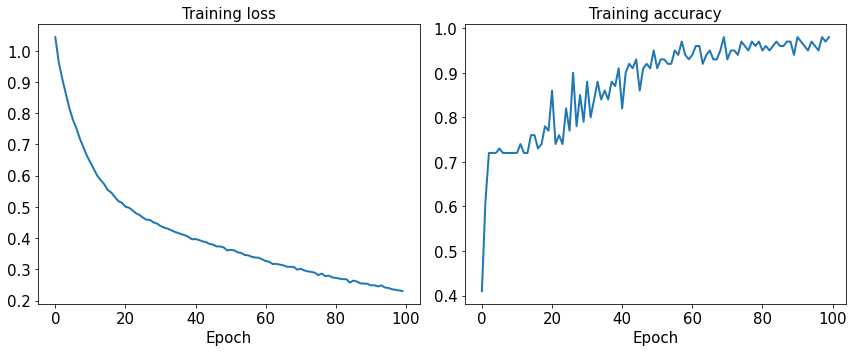

In [127]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=2)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=2)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

### Evaluating the trained model on the test dataset

Keras provides `.evaluate` method which provides evaluation that is consistent with the metrics used during training. 

In [128]:
results = iris_model.evaluate(test_dataset.batch(1), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.2414   Test Acc.: 0.9800


2022-01-04 01:19:15.966589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Notice that we have to batch the test dataset as well, to ensure that the input to the 
model has the correct rank, i.e. calling `.batch()` will increase the rank of the retrieved tensors by 1. Exact batch size used in evaluation doesn't matter. Here we used 1 which means 50 batches of size 1 will be processed.

### Saving and loading trained models

We can save a model for future use as follows:

In [64]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True, # also save state of optimizer 
                save_format='h5') 

Testing load:

In [65]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')
print(iris_model_new.summary())

results = iris_model_new.evaluate(test_dataset.batch(1), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None
Test loss: 0.2414   Test Acc.: 0.9800


2022-01-04 01:04:56.367247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


We can also save the network architecture as a JSON file.

In [66]:
import json

json_object = json.loads(iris_model_new.to_json())
print(json.dumps(json_object, indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            4
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "fc1_input"
        }
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "fc1",
          "trainable": true,
          "batch_input_shape": [
            null,
            4
          ],
          "dtype": "float32",
          "units": 16,
          "activation": "sigmoid",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": nu